<a href="https://colab.research.google.com/github/LazaroR-u/EQNN_for_HEP/blob/main/Electron_photon_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# electron photon dataset Preprocessing

In this Jupyter Notebook we load the electron-photon dataset, perform a quick data analysis and process to obtain reduced Q-G datasets per channel using different methods to reduce images like bilinear, Gaussian, Lanczos3, Lanczos5, and area.

The file consists of 4 datasets:

- X: energy deposited in the ECAL and tracker. (image of 3 channels)

- y: labels 0 or 1 for photon and electron, respectively. (a label)



## import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split


## load raw data

In [2]:
def electron_photon(sample = 100000):
    file_path_electron = "/content/electron.hdf5"
    with h5py.File(file_path_electron, "r") as file:
        X_e = np.array(file["X"])
        y_e = np.array(file["y"])

    file_path_photon = "/content/photon.hdf5"
    with h5py.File(file_path_photon, "r") as file:
        X_p = np.array(file["X"])
        y_p = np.array(file["y"])

    X = np.concatenate((X_e[:sample], X_p[:sample]), axis=0)
    y = np.concatenate((y_e[:sample], y_p[:sample]), axis=0)

    return X, y

There are three files:
- f : ~140000 samples
- f_train: ~800000 samples
- f_val: 10000 samples

Here, we are using only the f dataset with almost 140 000 samples

In [4]:
X, y = electron_photon( sample = 100000)

In [19]:
x_red = X
y_red = y
x_red.shape, y_red

((200000, 32, 32, 2), array([1., 1., 1., ..., 0., 0., 0.], dtype=float32))

In [28]:
jets_photon = x_red[y_red == 1][:10]
jets_photon.shape

(10, 32, 32, 2)

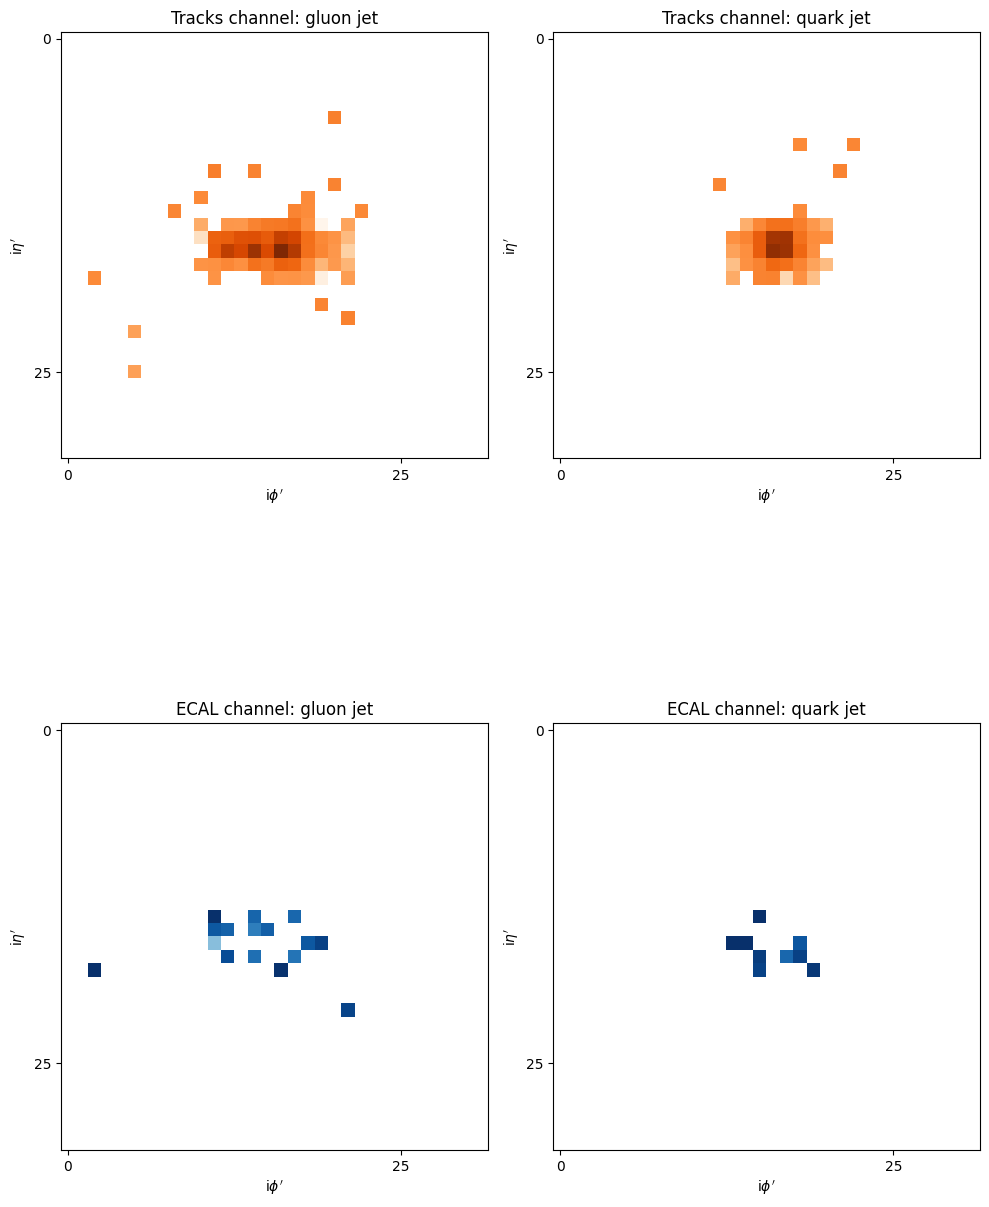

In [29]:
n = 2

jets_photon = x_red[y_red == 0][:10]
jets_electron = x_red[y_red == 1][:10]

# Define a LogNorm for logarithmic scaling
norm = mcolors.LogNorm()

fig, axs = plt.subplots(2, 2, figsize=(10, 15))

# Titles for each subplot
titles_photon = ["Tracks channel: photon jet", "ECAL channel: photon jet", "HCAL channel: photon jet"]
titles_electron = ["Tracks channel: electron jet", "ECAL channel: electron jet", "HCAL channel: electron jet"]
cmaps = ["Oranges", "Blues", "Greys"]
norms = [norm, norm, None]


# Plot photon images
for i in range(2):
    axs[i, 0].imshow(jets_photon[n, :, :, i], cmap=cmaps[i], norm=norms[i])
    axs[i, 0].set_title(titles_photon[i])
    axs[i, 0].set_xticks(np.arange(0, 33, 25))
    axs[i, 0].set_yticks(np.arange(0, 33, 25))

# Plot electron images
for i in range(2):
    axs[i, 1].imshow(jets_electron[n, :, :, i], cmap=cmaps[i], norm=norms[i])
    axs[i, 1].set_title(titles_electron[i])
    axs[i, 1].set_xticks(np.arange(0, 33, 25))
    axs[i, 1].set_yticks(np.arange(0, 33, 25))


for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")


# Improve layout
plt.tight_layout()
plt.show()

## divide into dataset per channel

visualization of the main intensity per pixel for each channel.

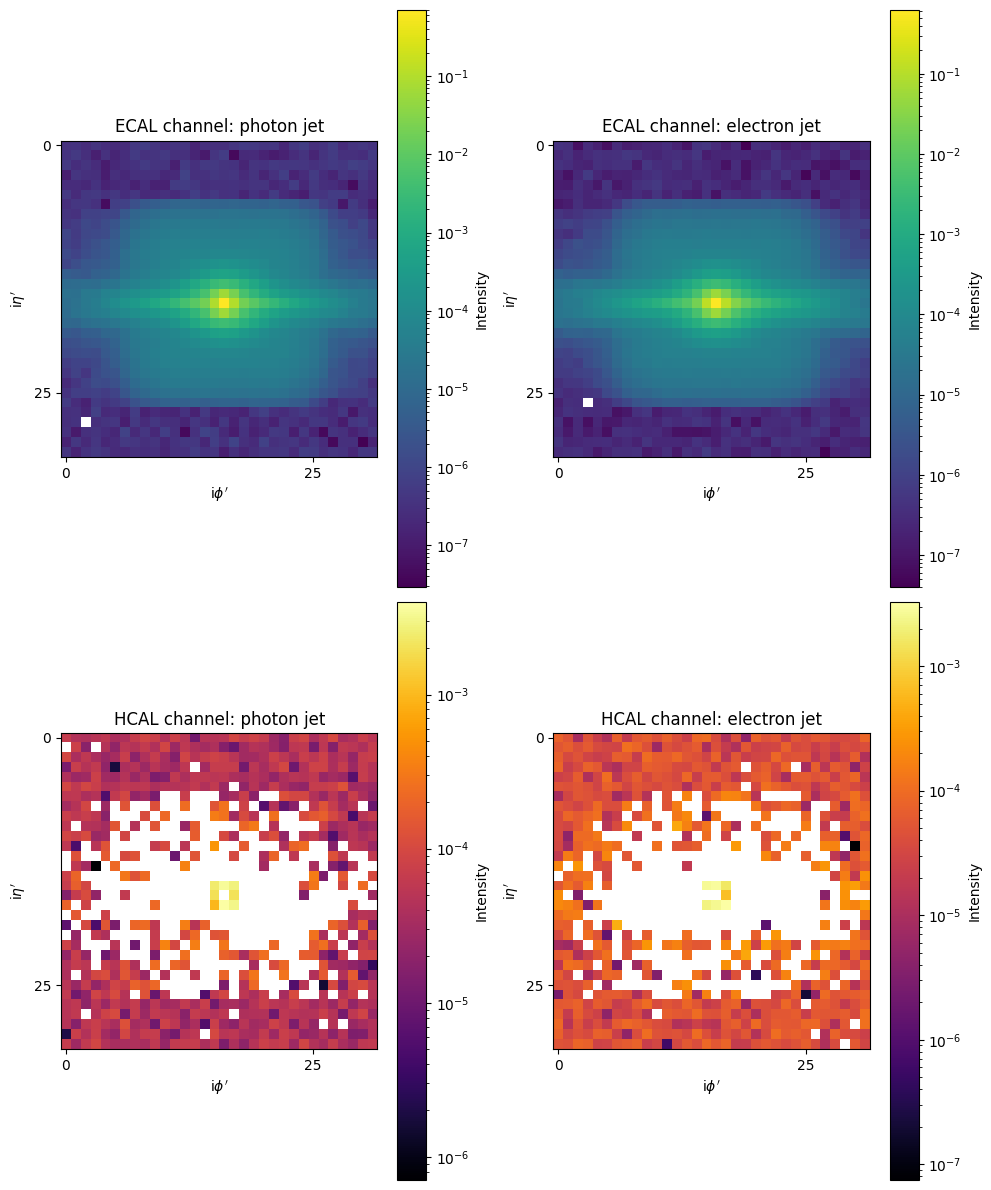

In [40]:
n_sample = 50000

# Calculate the average for each class
photon_avg = np.mean(x_red[y_red == 0][:n_sample], axis=0)
electron_avg = np.mean(x_red[y_red == 1][:n_sample], axis=0)


# Titles for each subplot
titles_photon = ["ECAL channel: photon jet", "HCAL channel: photon jet"]
titles_electron = ["ECAL channel: electron jet", "HCAL channel: electron jet"]
cmaps = ['viridis', "inferno", "hot_r", "cividis", "RdYlBu"]
norms = [norm, norm, norm]

## HCAL channel
# mean values plot for photons

fig, axs = plt.subplots(2, 2, figsize=(10, 12))

for i in range(2):
  im = axs[i, 0].imshow(photon_avg[:,:,i], norm=LogNorm(), cmap=cmaps[i])
  axs[i, 0].set_title(titles_photon[i])
  axs[i, 0].set_xticks(np.arange(0, 33, 25))
  axs[i, 0].set_yticks(np.arange(0, 33, 25))
  cbar = fig.colorbar(im, ax=axs[i, 0])
  cbar.ax.set_ylabel('Intensity')

# Plot electron images
for i in range(2):
  im = axs[i, 1].imshow(electron_avg[:,:,i], norm=LogNorm(), cmap = cmaps[i])
  axs[i, 1].set_title(titles_electron[i])
  axs[i, 1].set_xticks(np.arange(0, 33, 25))
  axs[i, 1].set_yticks(np.arange(0, 33, 25))
  cbar = fig.colorbar(im, ax=axs[i, 1])
  cbar.ax.set_ylabel('Intensity')

for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")

fig.tight_layout()
plt.show()

## resize and save to new file

There are different methods to crop and resize images, for example, Tensorflow has the following methods. The difference among them is in the sparsity that it presents in the cropped image.

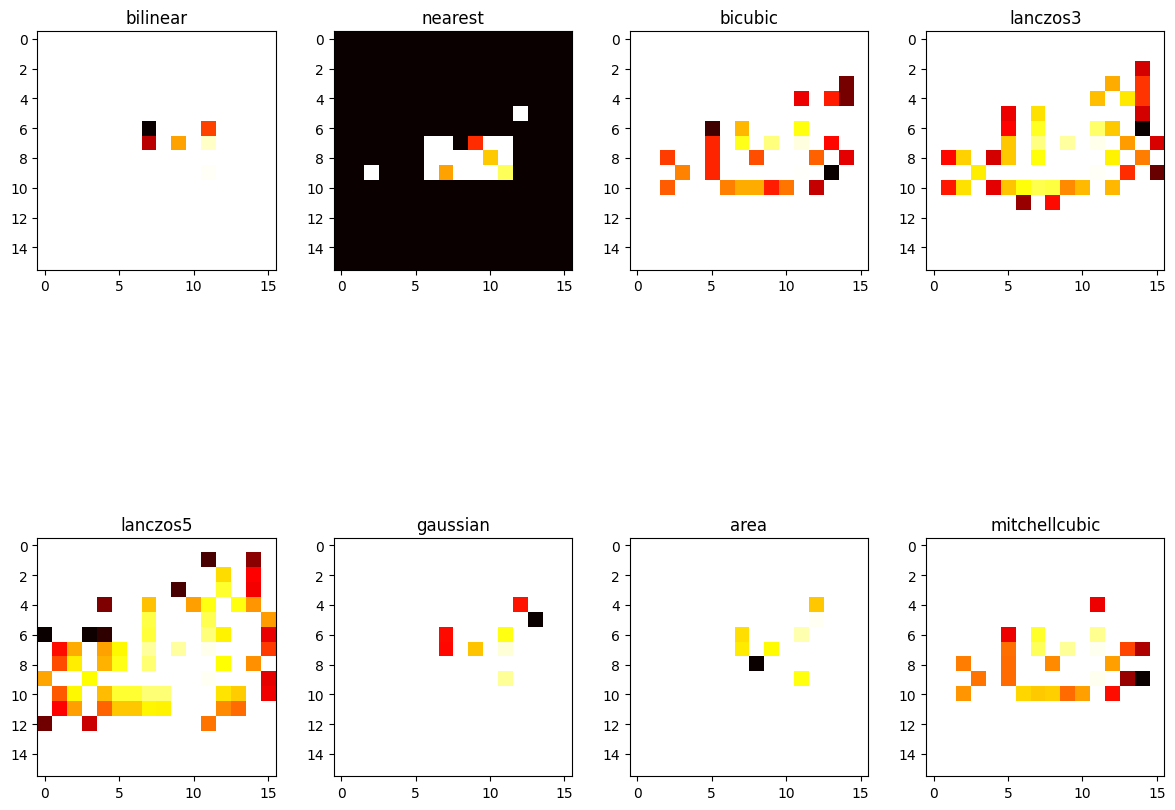

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Simulación de datos para el ejemplo
sample_data = x_red[5]
methods = ["bilinear", "nearest", "bicubic", "lanczos3", "lanczos5", "gaussian", "area", "mitchellcubic"]
channel = 1
scale = 16

# Crear la figura y los ejes para una cuadrícula de 4x2
fig, axs = plt.subplots(2, 4, figsize=(12, 12))

# Desactivar los ejes no utilizados
for ax in axs.flat:
    ax.set_visible(False)

# Graficar los métodos de reducción
for idx, method in enumerate(methods):
    row, col = divmod(idx, 4)
    cropped = tf.image.central_crop(sample_data[:, :, channel].reshape(32, 32, 1), 0.8)
    reduced_sample = tf.image.resize(cropped, (scale, scale), method=method).numpy()

    axs[row, col].imshow(reduced_sample, cmap="hot", norm=mcolors.LogNorm())
    axs[row, col].set_title(method)
    axs[row, col].set_visible(True)


# Ajustar el layout
fig.tight_layout()
plt.show()


The sparsity in these methods can be enlisted as follows (from less to greater sparsity):
1. neareast
2. bilinear
3. bicubic
4. gaussian
5. mitchellcubic
6. lanczos3
7. lanczos5
8. area


Let's focus on bilinear, lanczos3, lanczos5, and gaussian.

The different methods that can be used to reduce the dimension.
Usually cropping first and then resizing should be the best.

Fix some settings:

- batch size: how many samples to load into memory at once
- file name: name of output file
- output shape: shape the rescale images should have
- channel: which channel to use (in this case only ecal) - you could also rewrite to use all channels
- crop fraction: To what percent to crop down before rescaling

In [37]:
def crop_and_resize(images, channel, scale, crop_fraction=0.8, method='bilinear'):
    cropped_images = tf.image.central_crop(images[:, :, :, channel].reshape(-1, images.shape[1], images.shape[2], 1), crop_fraction)
    resized_images = tf.image.resize(cropped_images, (scale, scale), method=method).numpy()
    return resized_images

def process_and_save_data(x_data, y_data, batch_size, crop_fraction, method, output_shape, channel, file_name):
    n_data = x_data.shape[0]
    num_batches = n_data // batch_size
    events = num_batches * batch_size

    # Limitar los datos a un múltiplo del batch_size
    x_data = x_data[:events]
    y_data = y_data[:events]

    fnew = h5py.File(file_name, "w")
    dsetx = fnew.create_dataset("X", (events,) + output_shape, dtype='f')
    dsety = fnew.create_dataset("y", (events,), dtype='i')

    for i in range(num_batches):
        y_batch = y_data[i * batch_size: (i + 1) * batch_size]
        x_batch = x_data[i * batch_size: (i + 1) * batch_size]

        x_small = crop_and_resize(x_batch, channel, output_shape[0], crop_fraction=crop_fraction, method=method)

        # Normalizar las imágenes
        div1 = np.max(x_small, axis=(1, 2)).reshape((x_batch.shape[0], 1, 1, 1))
        div1[div1 == 0] = 1
        x_small = x_small / div1

        dsety[i * batch_size: (i + 1) * batch_size] = y_batch
        dsetx[i * batch_size: (i + 1) * batch_size] = x_small.reshape((x_small.shape[0],) + output_shape)
        print("Batch ", i, "/", num_batches, end="\r")

    fnew.close()

In [41]:
methods = ["bilinear", "lanczos3", "gaussian", "area", "lanczos5"]
channel = ["ECAL", "HCAL"]
output_shape = (16,16,1)

for meth in methods:
  for ch in range(2):
    process_and_save_data(
        x_data=x_red,
        y_data=y_red,
        batch_size=500,
        crop_fraction=0.8,
        method= meth,
        output_shape=output_shape,
        channel= ch,  # 0 = HCAL, 1 = ECAL, 2 = Tracker
        file_name= "EP" + "-" + meth + "-" + channel[ch] + "-" + str(output_shape)
    )

# visualizations

In [50]:
import pandas as pd

def plot_mean_pixel_distribution(x_data, y_data, channel=1, image_shape=(16, 16), figsize=(25, 18)):
    """
    Plots the mean pixel distribution for electron and photon data.

    Parameters:
    - x_data: numpy array of images.
    - y_data: numpy array of labels.
    - channel: channel to use for the data (default is 1 for ECAL).
    - image_shape: shape of the images (default is (16, 16)).
    - figsize: size of the figure (default is (25, 18)).
    """
    plt.figure(figsize=figsize)

    # Split electron and photon data
    electron = x_data[np.array(y_data) == 1]
    photon = x_data[np.array(y_data) == 0]
    channels =["tracker", "ECAL", "HCAL"]

    # Flatten the data
    electron_flat = np.array([img.reshape(np.prod(image_shape)) for img in electron])
    photon_flat = np.array([img.reshape(np.prod(image_shape)) for img in photon])

    # Calculate the mean value per pixel in each kind of data
    average_electron_pixel_values = np.mean(electron_flat, axis=0)
    average_photon_pixel_values = np.mean(photon_flat, axis=0)

    # Create a dataframe with the mean values for photon and electron data and a list with all the pixels
    df = {"pixel": np.arange(np.prod(image_shape)),
          "electron_value": average_electron_pixel_values,
          "photon_value": average_photon_pixel_values}
    df = pd.DataFrame(df)

    # Plot the distributions
    plt.plot(df["pixel"], df["electron_value"], label="electron pixel distribution")
    plt.plot(df["pixel"], df["photon_value"], label="photon pixel distribution")

    plt.xlabel('Pixel location')
    plt.ylabel('Intensity')
    plt.title(f'Mean pixel distribution for electron-photon data. Channel {channels[channel]}')
    plt.legend()
    plt.show()

    return (np.abs(average_electron_pixel_values) - np.abs(average_photon_pixel_values)).sum()

In [54]:
def process_and_plot_h5py_data(file_path, channel, method, figsize=(14, 10)):
    """
    Process and plot data from an HDF5 file.

    Parameters:
    - file_path: path to the HDF5 file.
    - channel: channel to use for the data.
    - method: method name for the title.
    - figsize: size of the figure for the pixel distribution plot (default is (15, 10)).
    """
    # Open HDF5 file and read data
    with h5py.File(file_path, "r") as f:
        x_data = f['X'][:]
        y_data = f['y'][:]

    # Plot a single sample
    plt.figure()
    plt.imshow(x_data[0], cmap='viridis', norm=LogNorm())
    plt.title(f"Data Sample. Channel {channel}. {method} method")
    plt.colorbar()
    plt.show()

    # Plot mean pixel distribution
    diff = plot_mean_pixel_distribution(x_data=x_data, y_data=y_data, channel=channel, figsize=figsize)

    # Plot average images for photons and electrons
    fig, axs = plt.subplots(1, 2, figsize=(11, 5))

    im1 = axs[0].imshow(np.average(x_data[y_data == 0], axis=0), norm=LogNorm(), cmap='inferno')
    axs[0].title.set_text('photon')
    cbar1 = fig.colorbar(im1, ax=axs[0])
    cbar1.ax.set_ylabel('Intensity')

    im2 = axs[1].imshow(np.average(x_data[y_data == 1], axis=0), norm=LogNorm(), cmap='inferno')
    axs[1].title.set_text('electron')
    cbar2 = fig.colorbar(im2, ax=axs[1])
    cbar2.ax.set_ylabel('Intensity')

    fig.tight_layout()
    plt.show()
    f.close()

    return diff


## bilinear

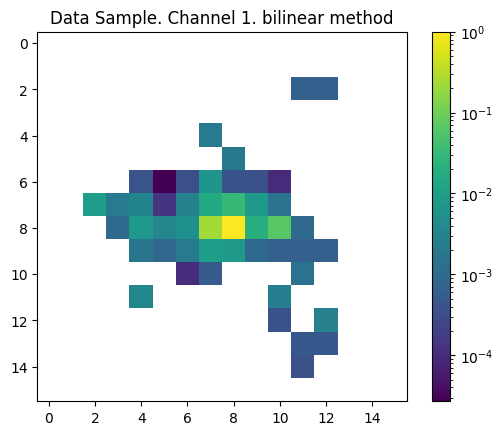

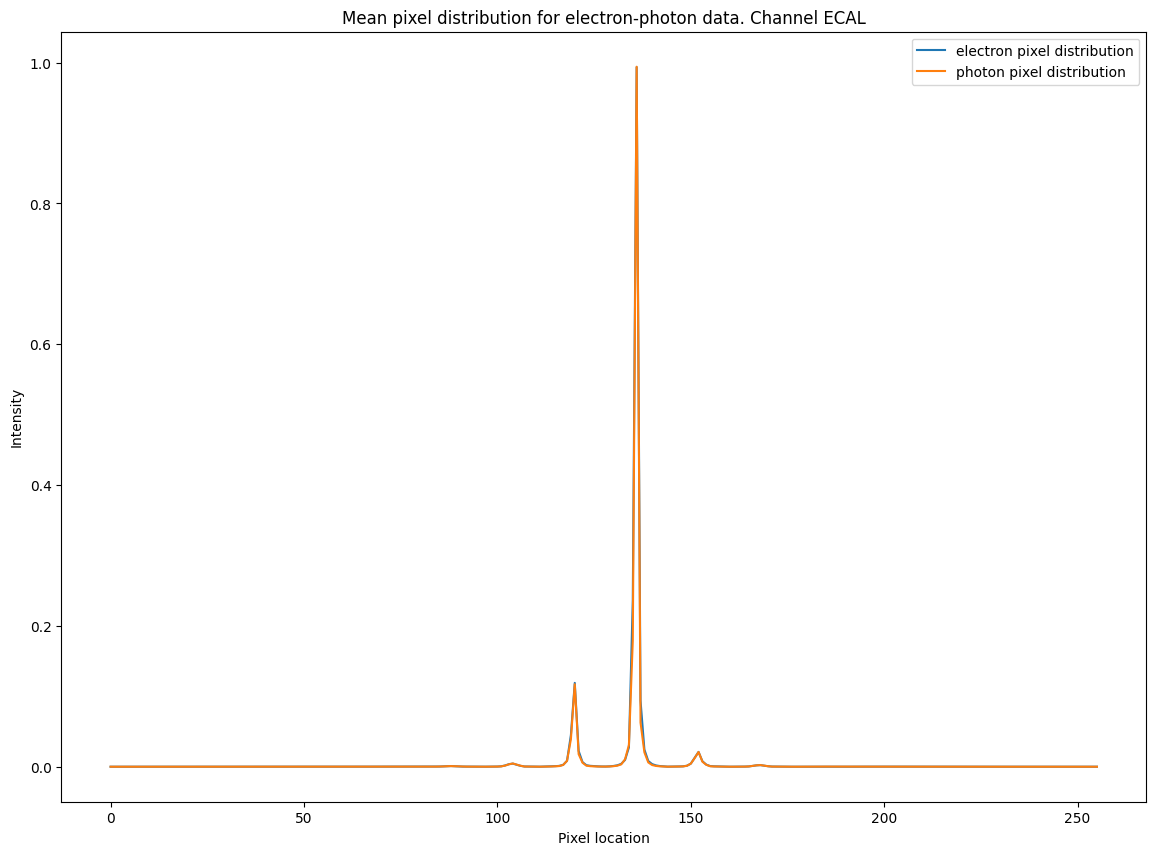

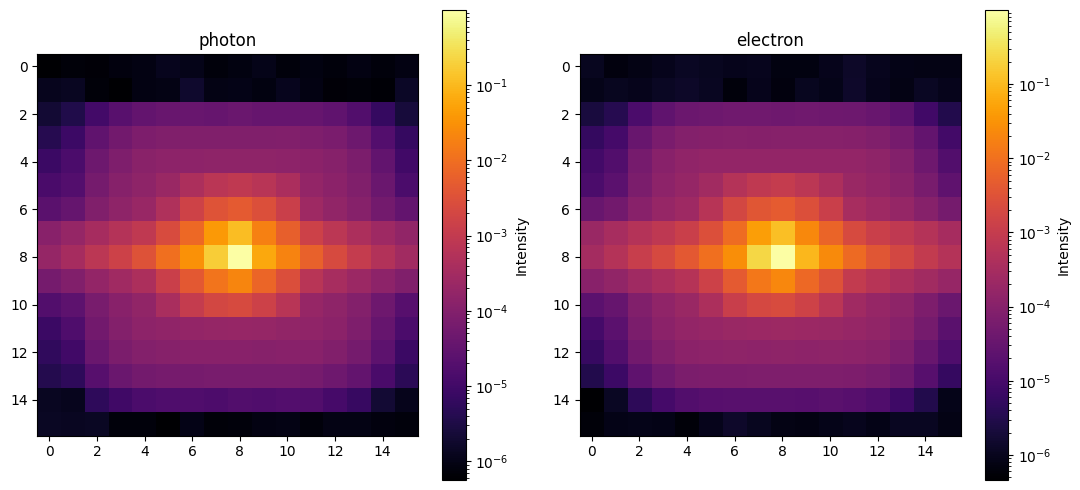

In [70]:
path = "/content/EP-bilinear-ECAL-(16, 16, 1)"
channel = 1 # 0 for tracker, 1 for ECAL, and 2 for HCAL
method = "bilinear" # ["area", "bilinear", "gaussian", "lanczos3", "lanczos5"]

diff_bi = process_and_plot_h5py_data(file_path=path, channel=channel, method=method)

## Gaussian

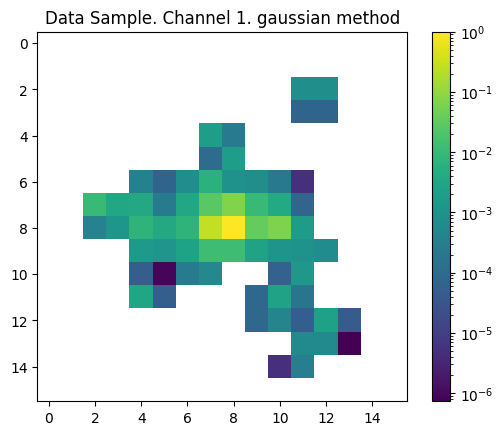

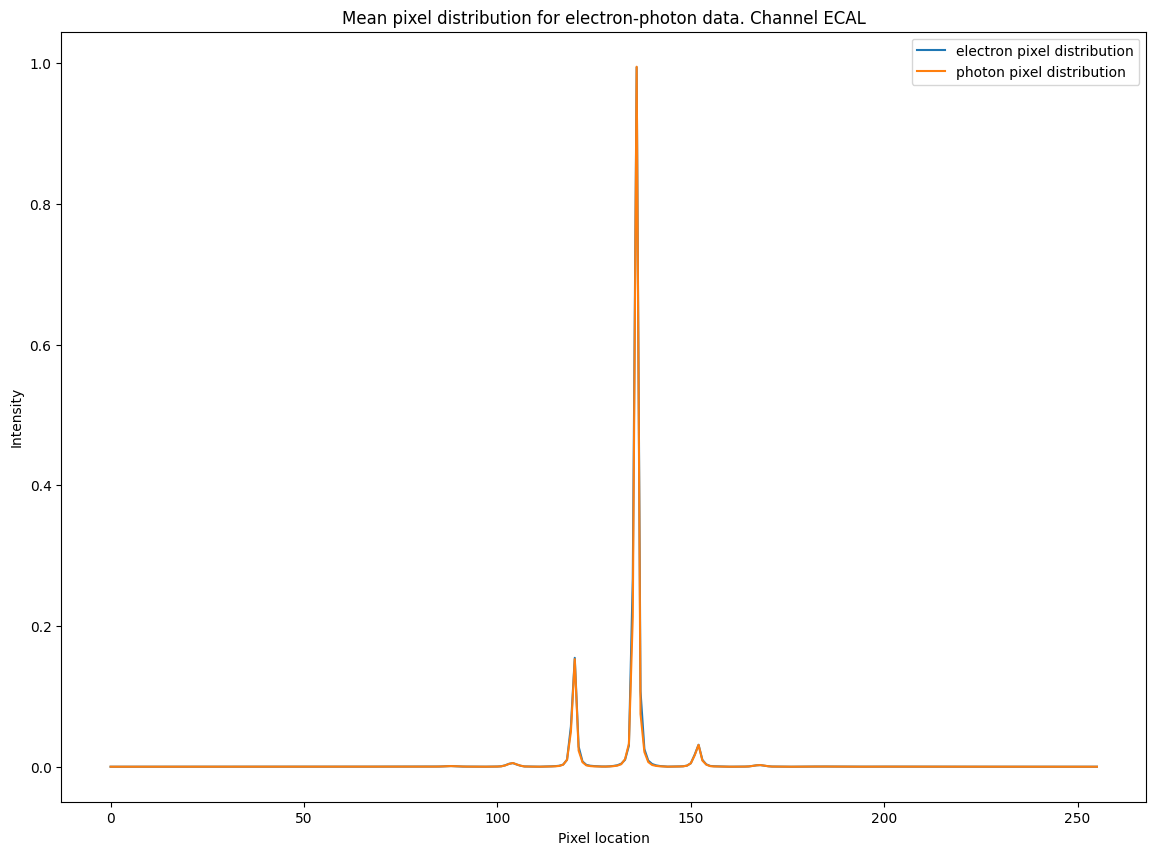

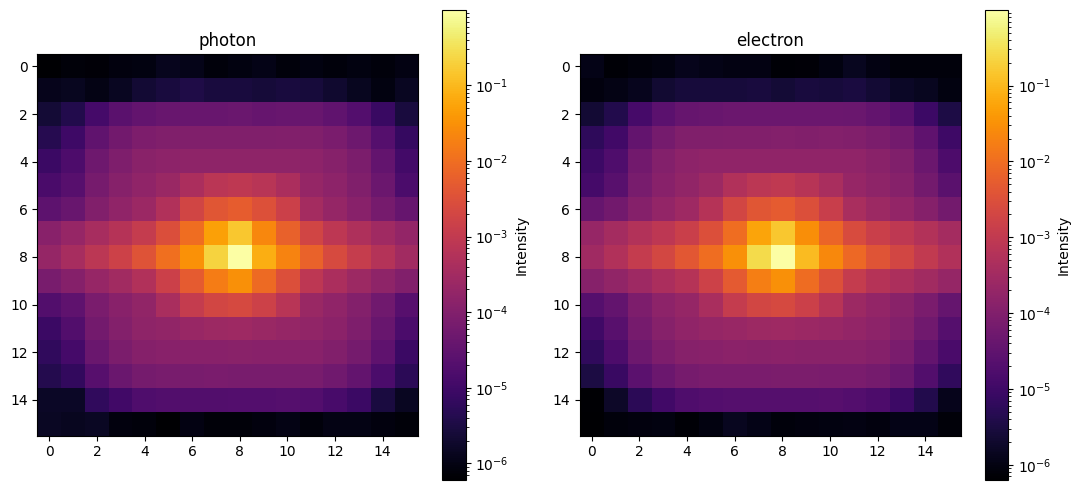

In [71]:
file_path = "/content/EP-gaussian-ECAL-(16, 16, 1)"
channel = 1
method = "gaussian"

diff_gauss = process_and_plot_h5py_data(file_path=file_path, channel=channel, method=method)

## lanczos3

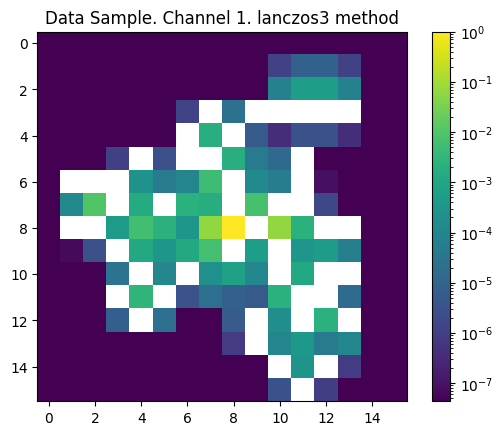

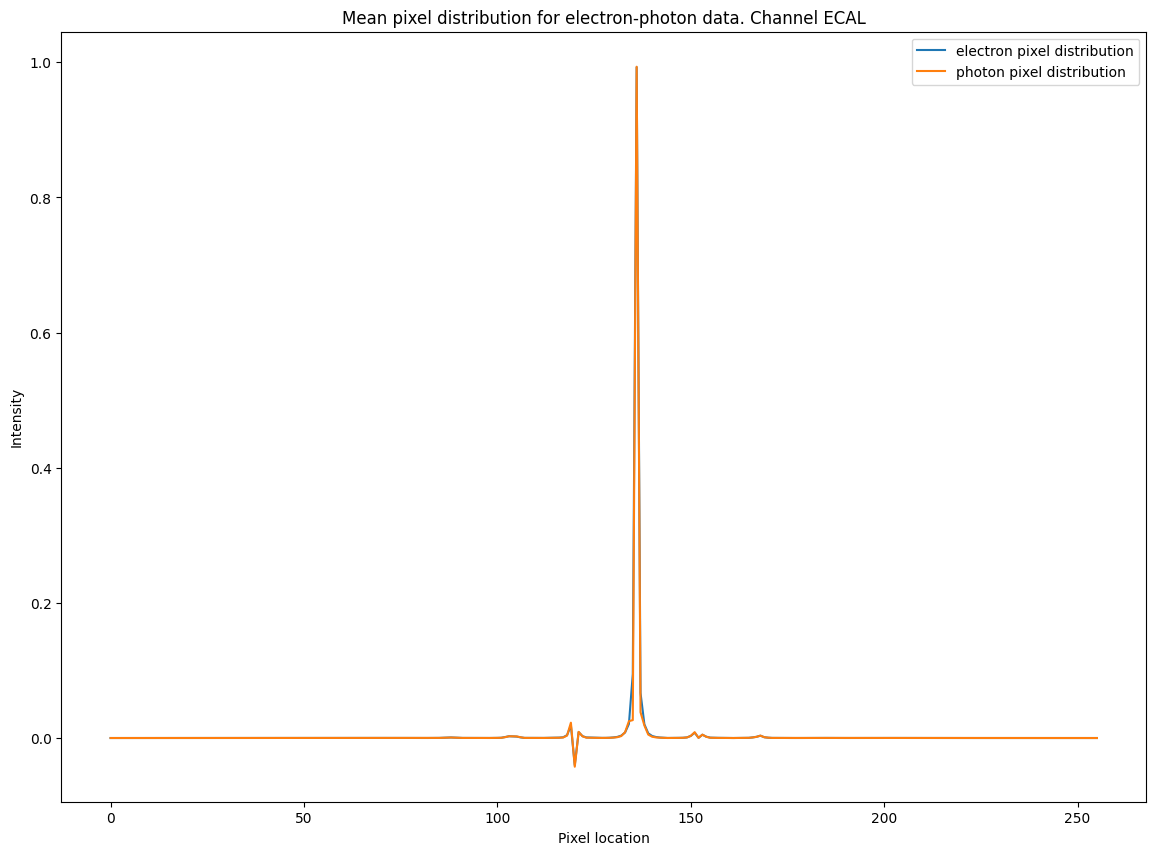

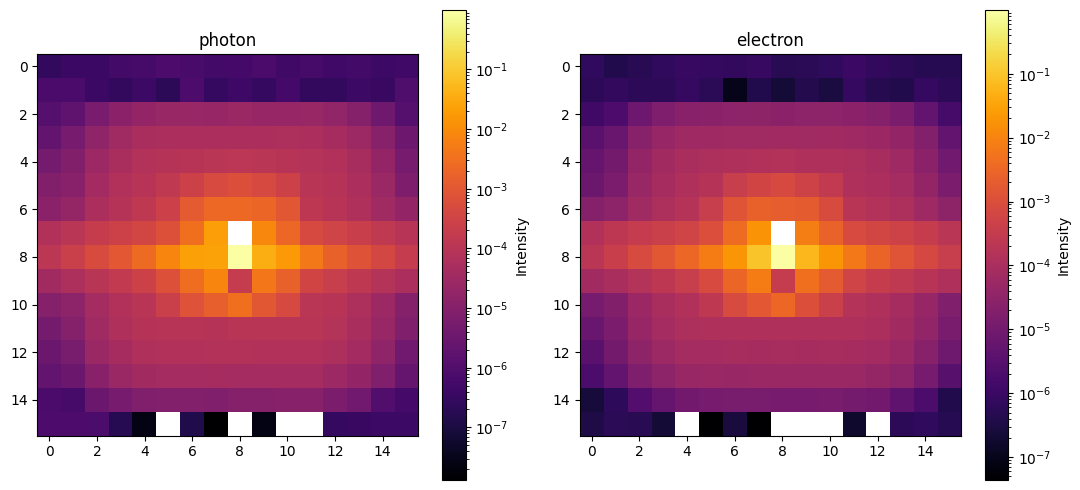

In [72]:
path = "/content/EP-lanczos3-ECAL-(16, 16, 1)"
channel = 1 # 0 for tracker, 1 for ECAL, and 2 for HCAL
method = "lanczos3" # ["area", "bilinear", "gaussian", "lanczos3", "lanczos5"]

diff_la3 = process_and_plot_h5py_data(file_path=path, channel=channel, method=method)

## lanczos5

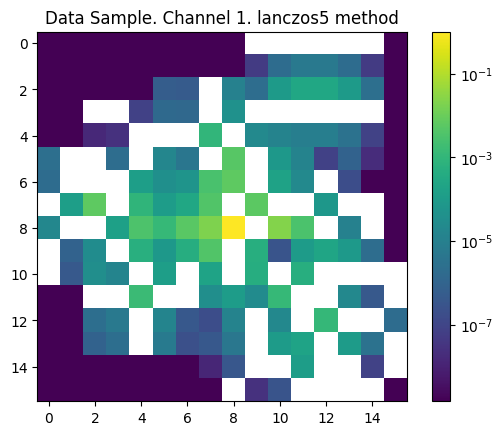

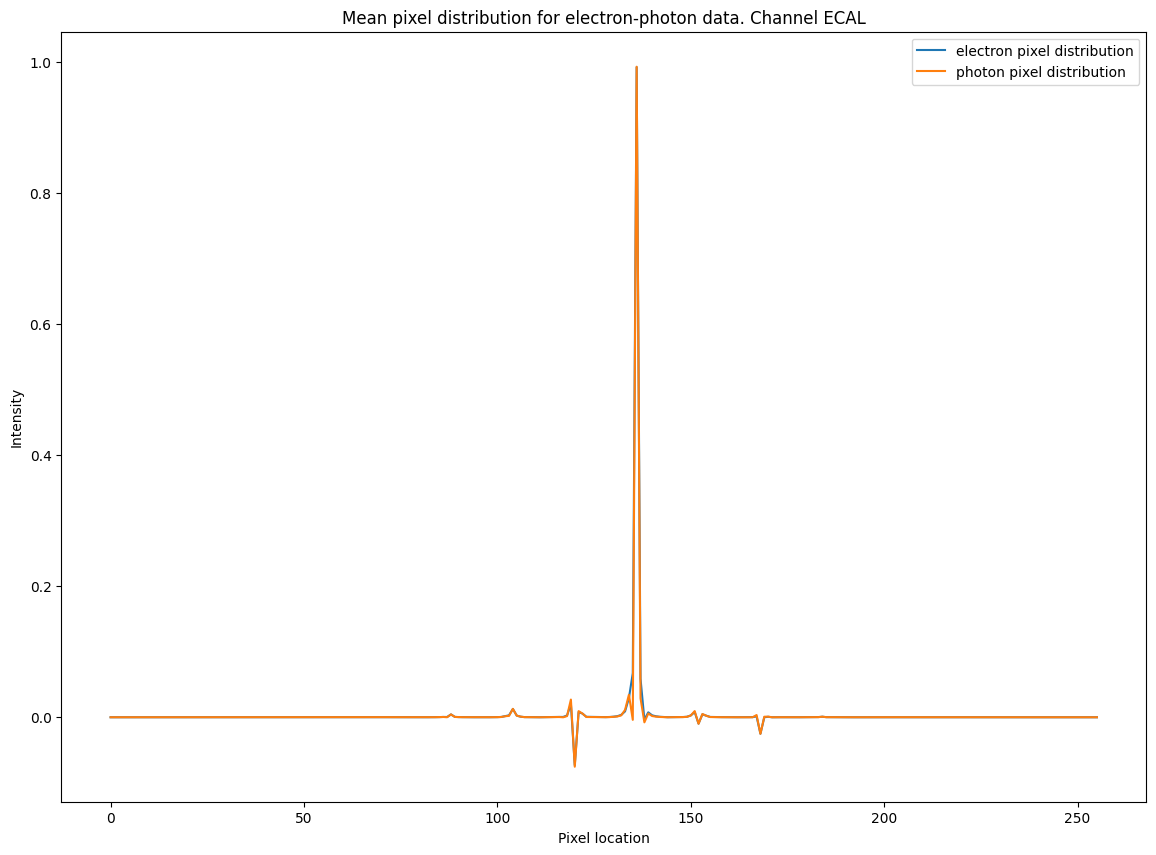

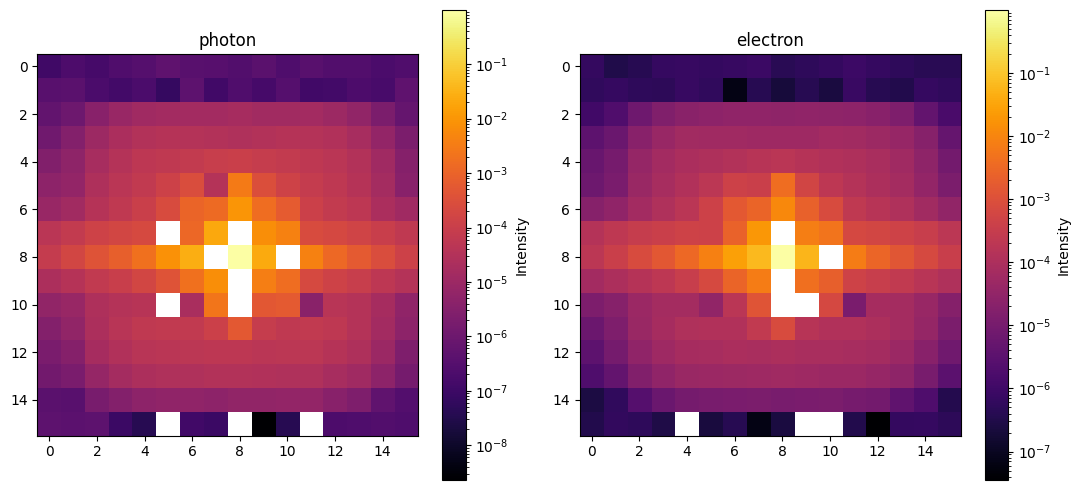

In [73]:
path = "/content/EP-lanczos5-ECAL-(16, 16, 1)"
channel = 1 # 0 for tracker, 1 for ECAL, and 2 for HCAL
method = "lanczos5" # ["area", "bilinear", "gaussian", "lanczos3", "lanczos5"]

diff_la5 = process_and_plot_h5py_data(file_path=path, channel=channel, method=method)

## area

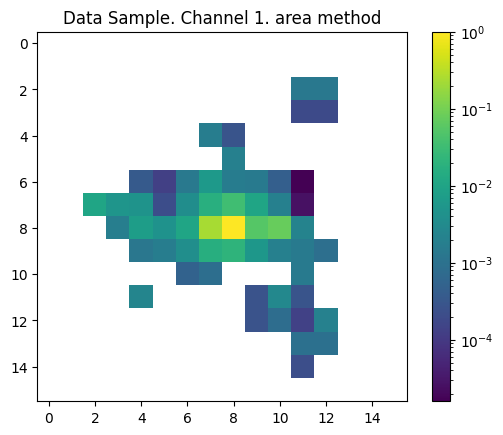

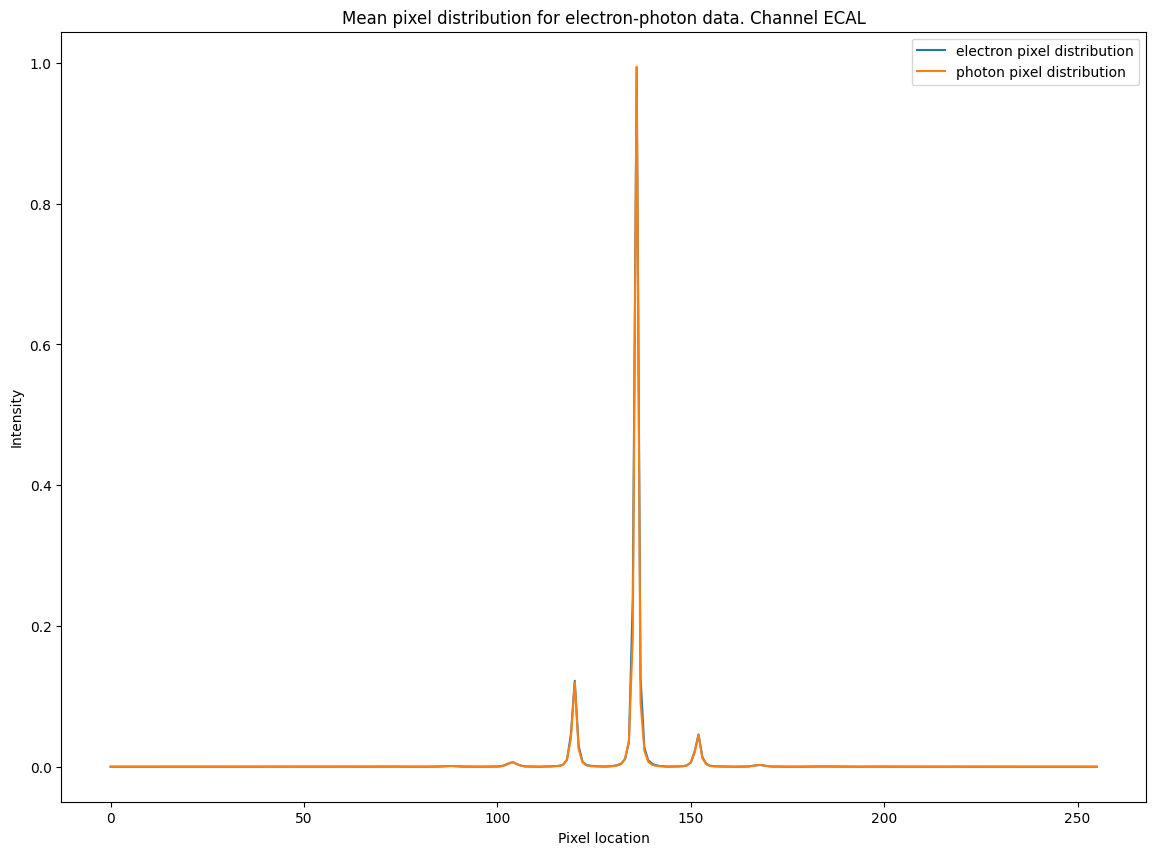

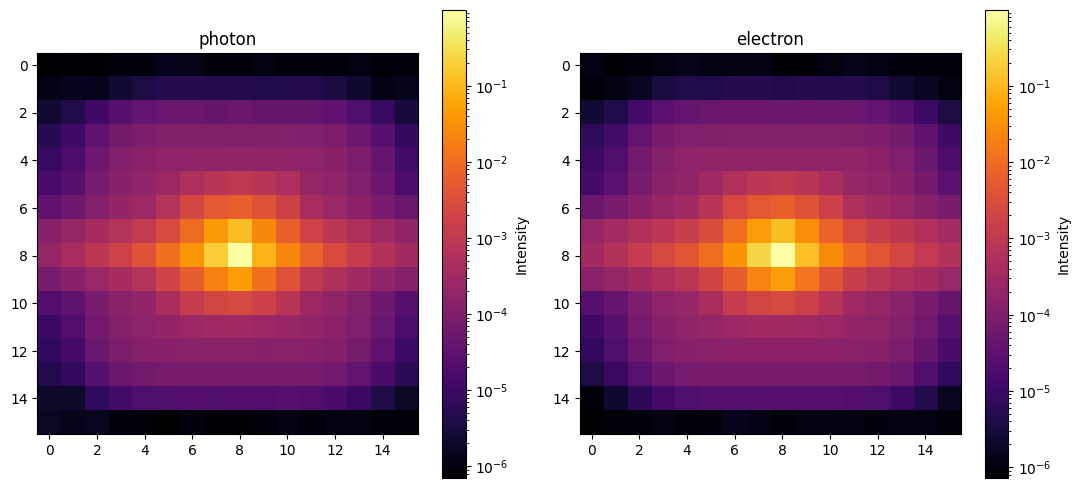

In [74]:
path = "/content/EP-area-ECAL-(16, 16, 1)"
channel = 1 # 0 for tracker, 1 for ECAL, and 2 for HCAL
method = "area" # ["area", "bilinear", "gaussian", "lanczos3", "lanczos5"]

diff_area = process_and_plot_h5py_data(file_path=path, channel=channel, method=method)

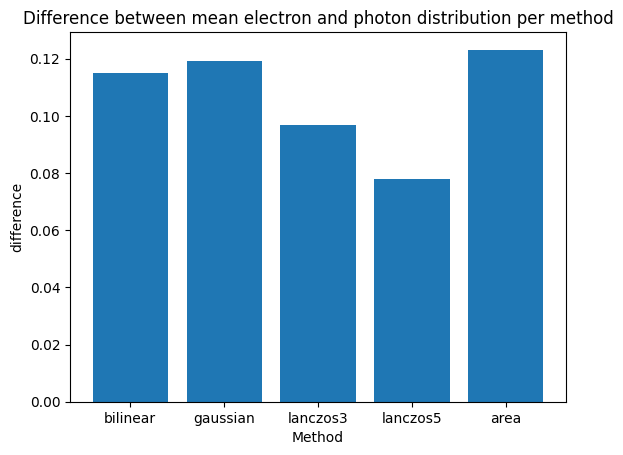

In [75]:
diff_dist_ECAL = {"bilinear": diff_bi,
            "gaussian": diff_gauss,
            "lanczos3":  diff_la3,
            "lanczos5": diff_la5,
            "area": diff_area,
}

plt.bar(diff_dist_ECAL.keys(), diff_dist_ECAL.values())
plt.xlabel("Method")
plt.ylabel("difference")
plt.title("Difference between mean electron and photon distribution per method")
plt.show()

As we can see, it seems like using area method is more remarkable the difference between electron and photon distributions.